In [416]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

train_df = pd.read_csv("https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/train.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528451801&Signature=IkCgr5i2gzmKXSWUjv2JvZNmOebppNpa%2Fqbt6arGni3ncDk3yX9%2B6wss2c39Ex42Zj6xlvplgsk3m3HbJveZtD7wavSKwM2gu17UC1TGktgGHVtdYXhR%2Bsnjx8ObLAzr9ZmUFFqYNT3F3eY4Toyn9BgMq7vBo3rDU7sndn1ZGEGWWaitBy34kjYLCCBrGACxP%2BuJauVbHaEpuHA7cc2pFUB6w3qZLrzn7kcKWo5aBdZZ3I1e%2FbcMo738LxJirq1MLoxsUvTrgqexhHTOf01QBCR07R8M1zxVROxkIYMV0ByVG7qrQNpO1h%2Ff%2B6xzQZgubR7CwPHzw%2F6N1dXNOk48Ww%3D%3D")
test_df = pd.read_csv("https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/test.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528451803&Signature=oBAfZBAe4qclF45NRGqXG%2Bi0zKBv0JdTaMbpm3KFOvdSm8PCJ9peLg47EWRvrev9rKKiSEH7nw2%2B0kSAeKYwMpCUCqi5ZFGxmIPfwJ6%2BU2%2BQe%2Fih9X6IATKT0sj4Z9UclxzJ141z6%2FkyAlZ%2BMVwuOYc%2B9oVboZ3JvG0YpWhB8z39kzpENoXj74XeQ78PpRPM8i5cr3ar1hAtTFeCkAuZ6SXLFZRjQYGyjYajA2zBBAzayXAcu0Klhcwjft2ZfjlTYpNwQahaGp8isN2AnBCOUESfyHn7Xt7rAaMGvssRGfHKxd7%2BejRqOsnMH3o8SfCa%2Fz%2Bg3uWUZCrCSdnr2xmdbA%3D%3D")

In [417]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, pearsonr

In [426]:
# is numeric? or not? 

cols = train_df.columns
NumericCols = []
nonNumericCols = []
for c in cols:
    col_dtype= train_df[c].dtype
    if col_dtype in ['int64', 'float64']:
        NumericCols.append(c)
    else:
        nonNumericCols.append(c)
print(NumericCols)

train_df['SalePrice_log'] = np.log(train_df['SalePrice'])
#train_df[NumericCols].corr()['SalePrice']
train_df[NumericCols].corr()['SalePrice_log'].sort_values(ascending=False)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'SalePrice_log']


SalePrice_log    1.000000
SalePrice        0.948374
OverallQual      0.817184
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489449
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355878
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209044
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057329
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorc

In [435]:
X = pd.DataFrame({'OverallQual':train_df['OverallQual'], })
def print_missing_and_skewness(col_name):
    print("missing: {}".format(train_df[col_name].isnull().sum()))
    print("skewness: {}".format(train_df[col_name].skew()))
# print_missing_and_skewness('OverallQual')

for col in train_df[NumericCols].corr()['SalePrice_log'].sort_values(ascending=False).index:
    print(col)
    print_missing_and_skewness(col)
    print("----")

SalePrice_log
missing: 0
skewness: 0.12133506220520406
----
SalePrice
missing: 0
skewness: 1.8828757597682129
----
OverallQual
missing: 0
skewness: 0.2169439277628693
----
GrLivArea
missing: 0
skewness: 1.3665603560164552
----
GarageCars
missing: 0
skewness: -0.3425489297486655
----
GarageArea
missing: 0
skewness: 0.17998090674623907
----
TotalBsmtSF
missing: 0
skewness: 1.5242545490627664
----
1stFlrSF
missing: 0
skewness: 1.3767566220336365
----
FullBath
missing: 0
skewness: 0.036561558402727165
----
YearBuilt
missing: 0
skewness: -0.613461172488183
----
YearRemodAdd
missing: 0
skewness: -0.5035620027004709
----
GarageYrBlt
missing: 81
skewness: -0.6494146238714679
----
TotRmsAbvGrd
missing: 0
skewness: 0.6763408364355531
----
Fireplaces
missing: 0
skewness: 0.6495651830548841
----
MasVnrArea
missing: 8
skewness: 2.669084210182863
----
BsmtFinSF1
missing: 0
skewness: 1.685503071910789
----
LotFrontage
missing: 259
skewness: 2.163569142324884
----
WoodDeckSF
missing: 0
skewness: 1.541

In [474]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def preprocessingX(input_df):
    r = pd.DataFrame({
        'OverallQual': input_df['OverallQual'], 
        'GrLivArea': np.log(input_df['GrLivArea']),
        'GarageCars': input_df['GarageCars']
    })
    r['GarageCars'] = r['GarageCars'].fillna(r['GarageCars'].mean())
    #r = r.fillna(r.mean())
    """
    for col in r.columns:
        print("col: {}, null count: {}".format(col, r[col].isnull().sum()))
        print("skewness: {}".format(r[col].skew()))
    """
    
    #handling na
    
    return MinMaxScaler().fit_transform(r)

X_train = preprocessingX(train_df)
X_test = preprocessingX(test_df)

Y = train_df['SalePrice']
Y_log = np.log(Y)

reg = GridSearchCV(RandomForestRegressor(), {'n_estimators':[5, 10, 20, 50]}, cv=3)
reg.fit(X_train, Y_log)

Y_pred = np.exp(reg.predict(X_train))
print(reg.score(X_train, Y_log))
#print(mean_squared_error(Y, Y_pred))


Y_test_pred = reg.predict(X_test)

0.953740377996


In [467]:
pd.DataFrame({'Id':test_df['Id'], 
              'SalePrice':np.exp( reg.predict(preprocessingX(test_df)))}).to_csv("180606_houseprice.csv", index=False)
print("complete")

col: GarageCars, null count: 0
skewness: -0.3425489297486655
col: GrLivArea, null count: 0
skewness: 1.3665603560164552
col: OverallQual, null count: 0
skewness: 0.2169439277628693
col: GarageCars, null count: 1
skewness: -0.10714151559186293
col: GrLivArea, null count: 0
skewness: 1.1304024140503506
col: OverallQual, null count: 0
skewness: 0.18119602092143566
(1460, 3) (1459, 3)
0.938605336319
col: GarageCars, null count: 1
skewness: -0.10714151559186293
col: GrLivArea, null count: 0
skewness: 1.1304024140503506
col: OverallQual, null count: 0
skewness: 0.18119602092143566


ValueError: Number of features of the model must match the input. Model n_features is 2 and input n_features is 3 

In [462]:
test_df['GarageCars'].fillna(test_df['GarageCars'].mean()).isnull().sum()

0

In [371]:

"""
- corr로 계산하면, numeric column들에 대해서만 계산됨.
- class 별로 서로 다른 분포를 가진다고 하면, class 별로 서로 다른 model을 세워서 적용하는 것 또한 하나의 방법이 됨 
- 
"""

train_df['log_SalePrice'] = np.log(train_df['SalePrice'])

"""numeric columns에 대해서는 평균으로 fillna를 모두 채워준다. 
"""
numeric_cols = train_df.corr()['SalePrice'].index
train_df[numeric_cols] = train_df[numeric_cols].fillna(lambda col: mean(col))

## 상위 부터 가져와보자. 
corr_df = pd.DataFrame({"corr":train_df.corr()['log_SalePrice'].sort_values(ascending=False).values[2:],
                       }, 
                       index = train_df.corr()['log_SalePrice'].sort_values(ascending=False).index[2:])
"""
- skewness가 높은 경우에는, 일괄적으로 np.log를 해주는 것이 좋은가? 
"""
corr_df['skew'] = train_df[corr_df.index].skew()
corr_df

,corr,skew
OverallQual,0.817184,0.216944
GrLivArea,0.700927,1.366560
GarageCars,0.680625,-0.342549
GarageArea,0.650888,0.179981
TotalBsmtSF,0.612134,1.524255
1stFlrSF,0.596981,1.376757
FullBath,0.594771,0.036562
YearBuilt,0.586570,-0.613461
YearRemodAdd,0.565608,-0.503562
TotRmsAbvGrd,0.534422,0.676341


In [394]:


pearsonr(np.log(train_df['SalePrice']), train_df['OverallQual'])

(0.81718441792168339, 0.0)

In [353]:

skew(train_df['log_SalePrice'])

0.1212103673013655

In [350]:

a = np.random.normal(0, 1, 10)
skew(a)

0.47480782422478895

In [227]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
"""
data exploration 을 해야 하는데, 
- numerical categorical 분류하고, 
- correlation matrix를 뽑아보자. 
"""
def preprocessingX(input_df):
    X = input_df[['OverallQual', 'OverallCond', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath',
                  'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'YrSold',
                  'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea'
             ]]
    for col in ['SaleCondition', 'SaleType', 'Street', 'BldgType', 'Condition1', 'ExterQual', 'ExterCond',
                'Functional'
               ]:
        X = X.join(pd.get_dummies(input_df[col], prefix=col))
    X = X.fillna(X.mean())
    X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
    return X
X = preprocessingX(train_df)
notX = train_df[ list(set(train_df.columns) - set(X.columns)) ]
Y = np.log(train_df['SalePrice'])


#train_x, test_x, train_y, test_y = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=42)

models = {
    #'linreg': GridSearchCV( LinearRegression(), {}),
    #'Ridge': GridSearchCV(Ridge(), {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]}),
    #'Lasso': GridSearchCV(Lasso(), {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]}),
    'ElasticNet': GridSearchCV(ElasticNet(), {'alpha':[0.001, 0.01, 0.1, 0.5, 1.0]}, cv=3),
    'rf1': GridSearchCV(RandomForestRegressor(), {'n_estimators':[2, 5]}, cv=3),
    'rf2': GridSearchCV(RandomForestRegressor(), {'n_estimators':[50]}, cv=3)
}
"""
    'MLPRegressor': GridSearchCV(MLPRegressor(), {'hidden_layer_sizes':[[10, 20, 10], [10, 10, 10, 10],
                                                                        #[32, 128, 256, 128, 32, 2]
                                                                       ],
                                              'activation':['relu', 'logistic'], 'solver':['adam']
                                             }),


"""


for k, m in models.items():
    m.fit(X, Y)
    print(k)
    print("train score: {:.3f}".format(m.score(X, Y)))
    print("mse: {}".format(mean_squared_error(Y, m.predict(X))))
    print("----------")
# notX.corr()['SalePrice'].sort_values(ascending=False)


best_model = sorted([m for k, m in models.items()], key=lambda m: m.score(X,Y))[-1]
#print(best_model)

for r in np.linspace(0.0, 1.0, 10):
    y_pred = models['rf1'].predict(X)*r + models['rf2'].predict(X)*(1-r)
    print(mean_squared_error(Y, y_pred))



pd.DataFrame({'Id':test_df['Id'], 
              'SalePrice':np.exp(best_model.predict(preprocessingX(test_df)))}).to_csv(
    "180601_houseprice.csv", index=False)
print("complete")


ElasticNet
train score: 0.869
mse: 0.020858482391253697
----------
rf1
train score: 0.964
mse: 0.005712310119705426
----------
rf2
train score: 0.980
mse: 0.00313364823227462
----------
0.00313364823227
0.00310306751573
0.00315176147519
0.00327973011066
0.00348697342214
0.00377349140963
0.00413928407313
0.00458435141265
0.00510869342817
0.00571231011971
complete


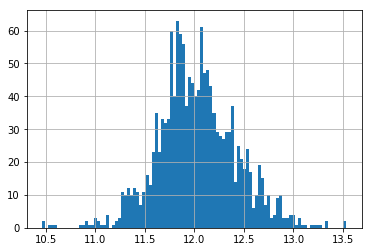

In [238]:
"""
그런데, 단순히 이렇게 normalization하는 것만으로 의미가 있나?
- 차이가 있다면, 차이가 더 있도록 만들고, 차이가 없다면 차이를 줄이도록 변수를 조절하는 것이 중요함. 
- normalization을 하는 것은 이 차이를 두드러지게 만들기 위함. 
"""
import seaborn as sns 

train_df['SalePrice'].apply(lambda x: np.log(x)).hist(bins=100)
plt.show()

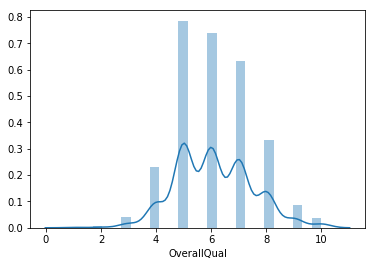

In [241]:
import seaborn as sns 

sns.distplot(train_df['OverallQual'])
plt.show()

In [182]:
test_df['HouseStyle'].isnull().sum()

0

In [149]:
notX['SaleType'].isnull().sum()

0

In [ ]:
pd.concat()